
# A20000021_AhmedAshraf_code
# &
# A20000726_MohamedIbrahim_code

# Dataset

https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

# Libraries,Data loading & preprocessing

In [ ]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

recipes = pd.read_csv('/kaggle/input/foodcom-recipes-and-reviews/recipes.csv')
reviews = pd.read_csv('/kaggle/input/foodcom-recipes-and-reviews/reviews.csv')

print("Recipes Dataset Info:")
print(recipes.info())
print("\nReviews Dataset Info:")
print(reviews.info())

Recipes Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  objec

In [ ]:
merged_data = pd.merge(reviews, recipes, on='RecipeId')

max_nutritional_values = [2000, 100, 13, 300, 2300, 325, 40, 40, 200]

In [ ]:
def preprocess_data(recipes, reviews, max_nutritional_values):

    recipes.fillna(0, inplace=True)
    reviews.fillna(0, inplace=True)

    # Filter recipes based on maximum nutritional values
    nutritional_columns = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                          'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
    for column, maximum in zip(nutritional_columns, max_nutritional_values):
        recipes = recipes[recipes[column] < maximum]

    scaler = StandardScaler()
    recipes[nutritional_columns] = scaler.fit_transform(recipes[nutritional_columns])

    tfidf = TfidfVectorizer(stop_words='english')
    recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].fillna('')
    tfidf_matrix = tfidf.fit_transform(recipes['RecipeIngredientParts'])

    return recipes, reviews, tfidf_matrix, scaler

recipes, reviews, tfidf_matrix, scaler = preprocess_data(recipes, reviews, max_nutritional_values)

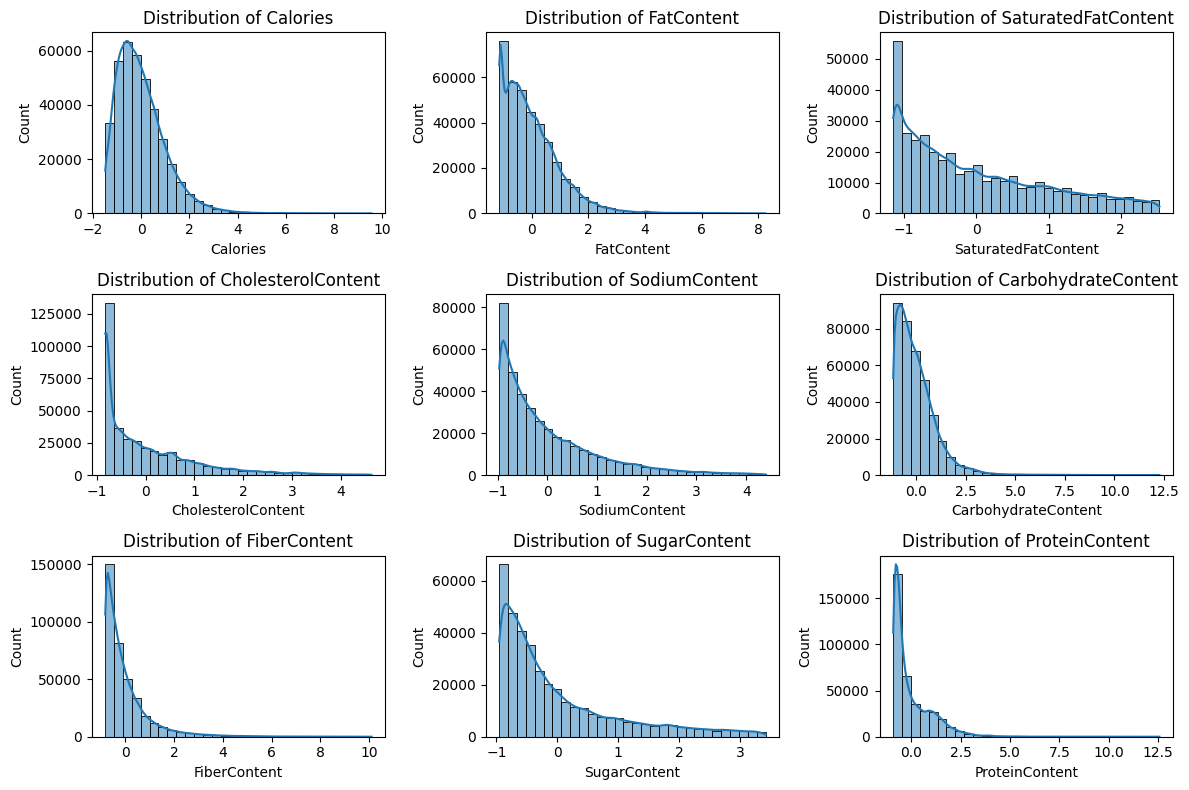

In [ ]:
plt.figure(figsize=(12, 8))
nutritional_columns = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
for i, column in enumerate(nutritional_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(recipes[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Content Based Recommendation

In [ ]:
def content_based_recommendation(input_recipe, recipes, tfidf_matrix, n_recommendations=10, batch_size=1000):

    nutritional_columns = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                          'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']

    input_scaled = scaler.transform(input_recipe.reshape(1, -1))
    nutritional_similarity = cosine_similarity(input_scaled, recipes[nutritional_columns])  # Shape: (1, num_recipes)

    tfidf_matrix_sparse = csr_matrix(tfidf_matrix)

    combined_similarity = np.zeros((1, len(recipes)))

    for i in range(0, len(recipes), batch_size):
        batch = tfidf_matrix_sparse[i:i + batch_size]
        text_similarity = cosine_similarity(batch, tfidf_matrix_sparse)  # Shape: (batch_size, num_recipes)

        nutritional_similarity_batch = nutritional_similarity[:, i:i + batch_size]  # Shape: (1, batch_size)
        text_similarity_mean = text_similarity.mean(axis=0).reshape(1, -1)  # Shape: (1, num_recipes)
        combined_similarity[:, i:i + batch_size] = 0.7 * nutritional_similarity_batch + 0.3 * text_similarity_mean[:, i:i + batch_size]

    indices = np.argsort(combined_similarity, axis=1)[:, -n_recommendations:]
    recommended_recipes = recipes.iloc[indices[0]]

    recommended_recipes[nutritional_columns] = scaler.inverse_transform(recommended_recipes[nutritional_columns])

    return recommended_recipes

In [ ]:
recipes_subset = recipes.head(100000)
tfidf_matrix_subset = tfidf_matrix[:100000]

input_recipe = np.array([170.9, 2.5, 1.3, 8, 29.8, 37.1, 3.6, 30.2, 3.2])  # Example input recipe nutritional values
content_recs = content_based_recommendation(input_recipe, recipes_subset, tfidf_matrix_subset, n_recommendations=10)
print("Content-Based Recommendations:")
print(content_recs[['RecipeId', 'Name', 'Calories', 'FatContent', 'ProteinContent']])

Content-Based Recommendations:
        RecipeId                               Name  Calories  FatContent  \
130112    136677           Cinnamon-Blueberry Sauce     155.9         0.4   
97438     102922              Fresh Blueberry Crisp     214.2         5.9   
88632      93886             Crock Pot Apple Butter     154.2         0.2   
47144      51163               Peachy Dessert Sauce     176.2         0.3   
2231        3741        Whole-Berry Cranberry Sauce     165.7         0.1   
68184      72788           My Mama's Carrot Tzimmes     179.9         4.5   
37917      41682        Cheesy Apple Pie in a Glass     167.3         0.4   
129179    135713                Peach Crumb Cobbler     194.5         2.9   
0             38  Low-Fat Berry Blue Frozen Dessert     170.9         2.5   
139613    146475              Brown Sugar Apple Pie     148.2         0.2   

        ProteinContent  
130112             0.8  
97438              2.9  
88632              0.3  
47144              1.

In [ ]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tabulate import tabulate

print("Content-Based Recommendations:")
print(tabulate(content_recs[['RecipeId', 'Name', 'Calories', 'FatContent', 'ProteinContent']],
               headers='keys', tablefmt='pretty', showindex=False))

Content-Based Recommendations:
+----------+-----------------------------------+--------------------+---------------------+--------------------+
| RecipeId |               Name                |      Calories      |     FatContent      |   ProteinContent   |
+----------+-----------------------------------+--------------------+---------------------+--------------------+
|  136677  |     Cinnamon-Blueberry Sauce      | 155.90000000000003 | 0.40000000000000036 | 0.8000000000000007 |
|  102922  |       Fresh Blueberry Crisp       |       214.2        |         5.9         | 2.9000000000000004 |
|  93886   |      Crock Pot Apple Butter       |       154.2        | 0.20000000000000107 | 0.3000000000000007 |
|  51163   |       Peachy Dessert Sauce        |       176.2        | 0.3000000000000007  | 1.0999999999999996 |
|   3741   |    Whole-Berry Cranberry Sauce    |       165.7        | 0.10000000000000142 | 0.3000000000000007 |
|  72788   |     My Mama's Carrot Tzimmes      |       179.9     

# Collaborative Filtering Recommendation

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV

def collaborative_filtering_recommendation(user_id, reviews, n_recommendations=10):

    reader = Reader(rating_scale=(1, 5))
    subset = reviews.sample(frac=0.3, random_state=42)  # Use 30% of the data for hyperparameter tuning
    data = Dataset.load_from_df(subset[['AuthorId', 'RecipeId', 'Rating']], reader)

    param_grid = {'n_factors': [50, 100, 150], 'n_epochs': [20, 30], 'lr_all': [0.005, 0.01]}

    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
    gs.fit(data)

    algo = gs.best_estimator['rmse']
    trainset = data.build_full_trainset()
    algo.fit(trainset)

    all_recipes = reviews['RecipeId'].unique()

    user_recipes = reviews[reviews['AuthorId'] == user_id]['RecipeId'].unique()

    unseen_recipes = [recipe for recipe in all_recipes if recipe not in user_recipes][:1000]  # Limit to 1000 recipes

    predictions = [algo.predict(user_id, recipe) for recipe in unseen_recipes]

    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n_recommendations]

    return [recipe.iid for recipe in top_n]

In [ ]:
user_id = 2008
collab_recs = collaborative_filtering_recommendation(user_id, reviews, n_recommendations=10)
print("Collaborative Filtering Recommendations:")
print(collab_recs)

Collaborative Filtering Recommendations:
[6536, 3370, 8953, 3877, 9974, 8674, 10205, 5335, 7537, 3748]


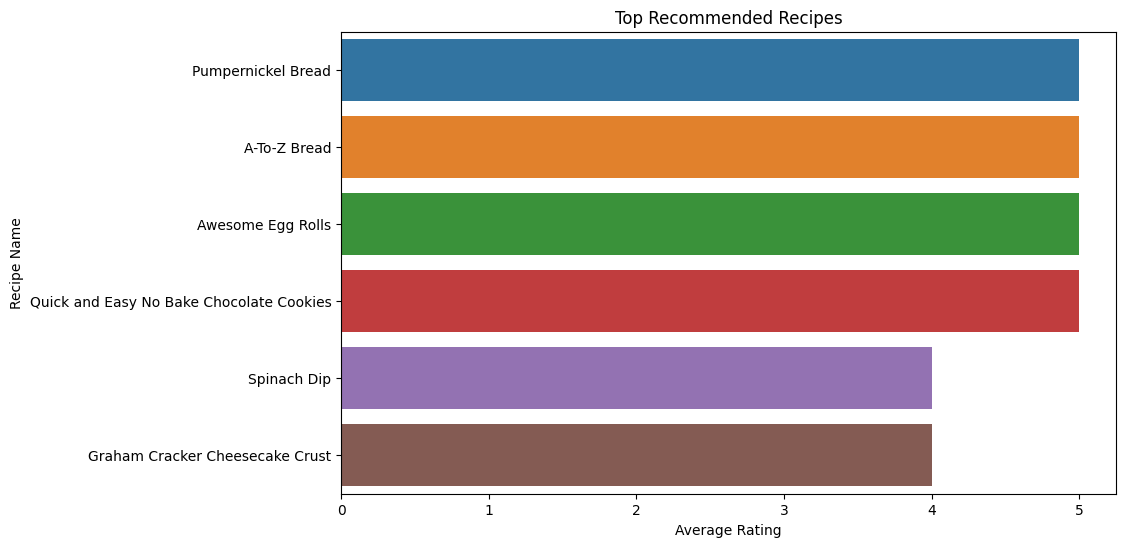

In [ ]:
def visualize_recommendations(recommendations, reviews, recipes):

    top_recipes = reviews[reviews['RecipeId'].isin(recommendations)].merge(
        recipes[['RecipeId', 'Name']], on='RecipeId', how='left'
    )

    top_recipes = top_recipes.drop_duplicates(subset=['RecipeId'])

    if top_recipes.empty:
        print("No recommendations found.")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Rating', y='Name', data=top_recipes.sort_values('Rating', ascending=False))
    plt.title('Top Recommended Recipes')
    plt.xlabel('Average Rating')
    plt.ylabel('Recipe Name')
    plt.show()

visualize_recommendations(collab_recs, reviews, recipes)

+----------+------------------------------------------+--------+
| RecipeId |                   Name                   | Rating |
+----------+------------------------------------------+--------+
|   5335   |            Pumpernickel Bread            |   5    |
|   5335   |            Pumpernickel Bread            |   5    |
|   3877   |                   nan                    |   5    |
|   3748   |               A-To-Z Bread               |   5    |
|   6536   |                   nan                    |   5    |
|   7537   |     Graham Cracker Cheesecake Crust      |   4    |
|   9974   |               Spinach Dip                |   4    |
|  10205   | Quick and Easy No Bake Chocolate Cookies |   5    |
|  10205   | Quick and Easy No Bake Chocolate Cookies |   5    |
|   8674   |            Awesome Egg Rolls             |   5    |
|   3370   |                   nan                    |   5    |
|   8953   |                   nan                    |   5    |
|  10205   | Quick and Ea

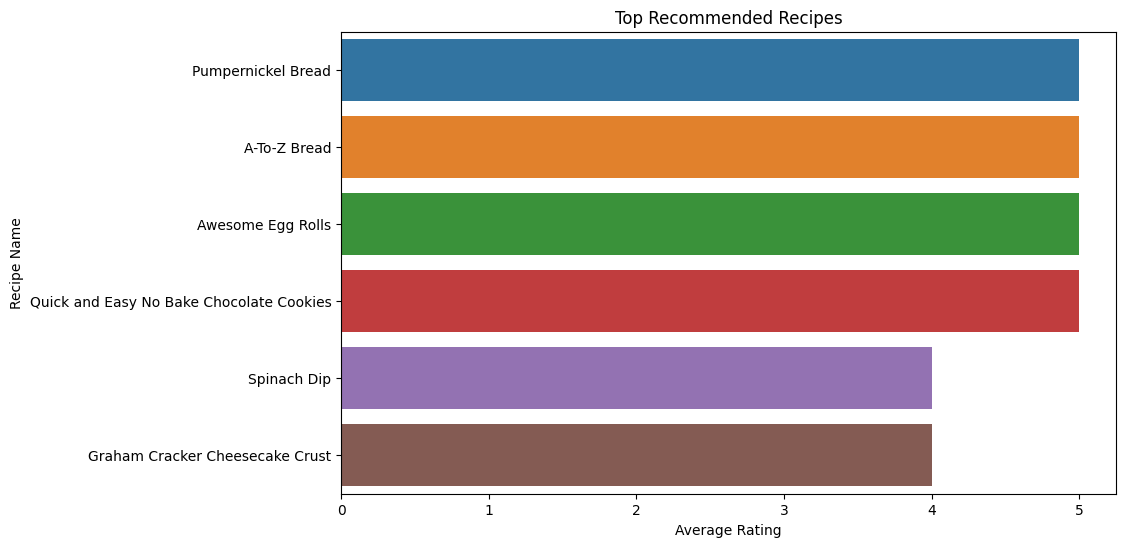

In [ ]:
recommended_recipes = reviews[reviews['RecipeId'].isin(collab_recs)].merge(
    recipes[['RecipeId', 'Name']], on='RecipeId', how='left'
)

print(tabulate(recommended_recipes[['RecipeId', 'Name', 'Rating']],
               headers='keys', tablefmt='pretty', showindex=False))

def visualize_recommendations(recommendations, reviews, recipes):
    """
    Visualize the top recommended recipes.
    """
    # Merge reviews with recipes to get the recipe names
    top_recipes = reviews[reviews['RecipeId'].isin(recommendations)].merge(
        recipes[['RecipeId', 'Name']], on='RecipeId', how='left'
    )

    top_recipes = top_recipes.drop_duplicates(subset=['RecipeId'])

    if top_recipes.empty:
        print("No recommendations found.")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Rating', y='Name', data=top_recipes.sort_values('Rating', ascending=False))
    plt.title('Top Recommended Recipes')
    plt.xlabel('Average Rating')
    plt.ylabel('Recipe Name')
    plt.show()

visualize_recommendations(collab_recs, reviews, recipes)

# Hybrid Recommender

In [ ]:
def hybrid_recommendation(user_id, input_recipe, recipes, reviews, tfidf_matrix, max_nutritional_values, n_recommendations=10):
    """
    Combine content-based and collaborative filtering for hybrid recommendations.
    """
    # Get content-based recommendations
    content_recs = content_based_recommendation(input_recipe, recipes, tfidf_matrix, n_recommendations)

    # Get collaborative filtering recommendations
    collab_recs = collaborative_filtering_recommendation(user_id, reviews, n_recommendations)

    # Combine recommendations (remove duplicates)
    hybrid_recs = list(set(content_recs['RecipeId'].tolist() + collab_recs))

    # Return top N hybrid recommendations
    return hybrid_recs[:n_recommendations]

# Evaluation

In [ ]:
recommendations = hybrid_recommendation(user_id, input_recipe, recipes, reviews, tfidf_matrix, max_nutritional_values, n_recommendations=10)
print("Hybrid Recommendations:", recommendations)

def evaluate_model(reviews):
    """
    Evaluate the collaborative filtering model using cross-validation.
    """
    # Load data into Surprise format
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(reviews[['AuthorId', 'RecipeId', 'Rating']], reader)

    # Define SVD model
    algo = SVD()

    # Perform cross-validation
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)

    # Print RMSE
    print("Cross-Validation RMSE:", results['test_rmse'].mean())

# Evaluate the model
evaluate_model(reviews)

Hybrid Recommendations: [500481, 6536, 444942, 314004, 469399, 9116, 336285, 373791, 3748, 3877]
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2280  1.2278  1.2299  1.2286  0.0010  
Fit time          19.65   20.12   20.20   19.99   0.24    
Test time         4.54    3.21    3.92    3.89    0.55    
Cross-Validation RMSE: 1.2285657780442316


# Visualise The Hybrid Recommendation

Top Hybrid Recommendation:
+----------+--------------+--------------------+-------------------+---------------------+--------------------+
| RecipeId |     Name     |      Calories      |    FatContent     |   ProteinContent    |       Rating       |
+----------+--------------+--------------------+-------------------+---------------------+--------------------+
|   3748   | A-To-Z Bread | 0.5365402544340938 | 0.703536973719064 | -0.5721761988149869 | 4.7727272727272725 |
+----------+--------------+--------------------+-------------------+---------------------+--------------------+


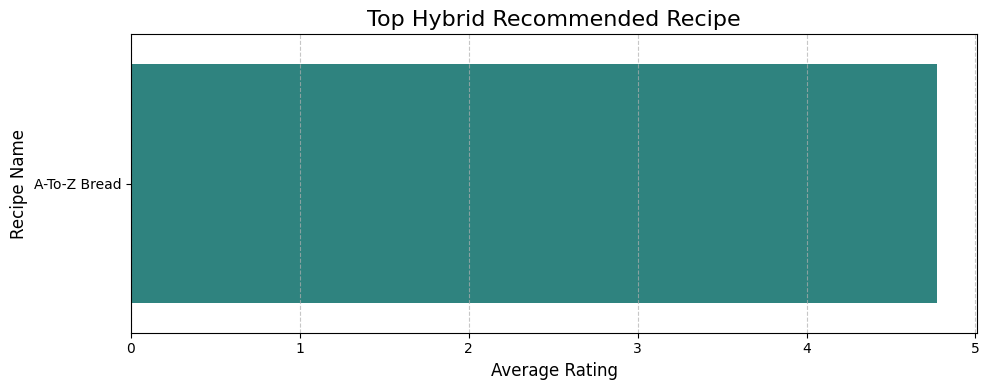

In [ ]:
# Merge recommendations with recipes to get details
hybrid_recipes = recipes[recipes['RecipeId'].isin(recommendations)].merge(
    reviews[['RecipeId', 'Rating']].groupby('RecipeId').mean().reset_index(),
    on='RecipeId', how='left'
)

# Sort by rating and select the top recipe
top_1_recipe = hybrid_recipes.sort_values('Rating', ascending=False).head(1)

# Display the top recommendation in a table
print("Top Hybrid Recommendation:")
print(tabulate(
    top_1_recipe[['RecipeId', 'Name', 'Calories', 'FatContent', 'ProteinContent', 'Rating']],
    headers='keys', tablefmt='pretty', showindex=False
))

# Visualize the top recommendation
plt.figure(figsize=(10, 4))
sns.barplot(x='Rating', y='Name', data=top_1_recipe, palette='viridis')
plt.title('Top Hybrid Recommended Recipe', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Recipe Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()